# Datacube NDVI example
Use the datacube api to access a region of Landsat 8 data.
Perform some band maths and produce an image.
Pixel drill accross time at a point location.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import xray
import numpy
import datacube.api

In [2]:
api = datacube.api.API()

In [3]:
data_request = {
    'satellite': 'LANDSAT_8',
    'product': 'EODS_NBAR',
}
data_descriptor = api.get_descriptor(data_request)
print("This request covers {} files.".format(len(data_descriptor['LS8 NBAR']['storage_units'])))
del data_descriptor['LS8 NBAR']['storage_units']  # Hide the storage units for readability
data_descriptor

This request covers 156 files.


{u'LS8 NBAR': {'buffer_size': None,
  'dimensions': ('time', 'latitude', 'longitude'),
  'irregular_indices': None,
  'result_max': (1445125843.0, -34.0, 150.99975),
  'result_min': (1420242644.0, -37.99975, 148.0),
  'result_shape': (17, 16000, 12000),
  'variables': {u'band_1': {'datatype': dtype('int16'), 'nodata': -999},
   u'band_2': {'datatype': dtype('int16'), 'nodata': -999},
   u'band_3': {'datatype': dtype('int16'), 'nodata': -999},
   u'band_4': {'datatype': dtype('int16'), 'nodata': -999},
   u'band_5': {'datatype': dtype('int16'), 'nodata': -999},
   u'band_6': {'datatype': dtype('int16'), 'nodata': -999},
   u'band_7': {'datatype': dtype('int16'), 'nodata': -999}}}}

There are 12 time slices availible in our date range.

Now to request the data.

In [4]:
data_request = {
    'satellite': 'LANDSAT_8',
    'product': 'EODS_NBAR',
    'variables': ('band_4', 'band_5'),
    'dimensions': {
        'latitude': {
            'range': (-36.2,-34.8)
        },
        'longitude': {
            'range': (148.4,149.5)
        },
        'time': {
            'range': (datetime.datetime(2000, 8, 1), datetime.datetime(2015, 8, 1, 9, 50, 23))
        }
    }
}
data = api.get_data(data_request)

In [5]:
data['arrays'].keys()

[u'band_4', u'band_5']

In [6]:
band_red = data['arrays']['band_4']
band_red.shape

(12, 5601, 4401)

We can select the first time slice by index

In [7]:
band_nir = data['arrays']['band_5']
band_nir.isel(time=0).shape

(5601, 4401)

Plot it using matplotlib

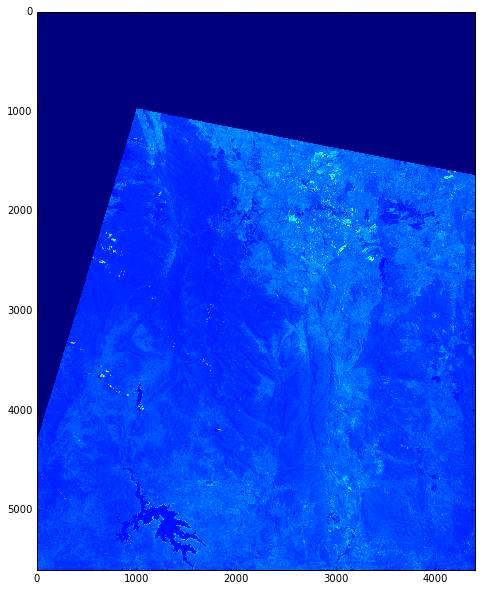

In [8]:
plt.figure(figsize=(8,10))
plt.imshow(band_red.isel(time=0))

Near Infraread looks pretty cool

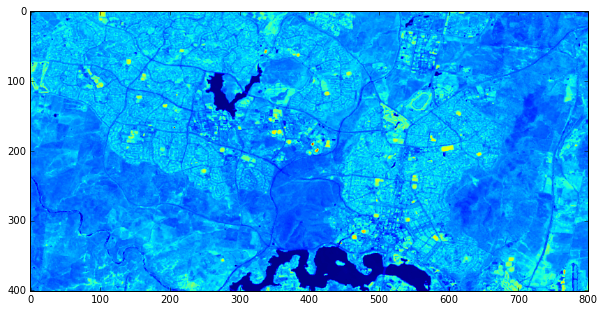

In [9]:
plt.figure(figsize=(10,7))
plt.imshow(band_nir.isel(time=0).sel(latitude=slice(-35.2,-35.3), longitude=slice(149.0, 149.2)) / 10000.0)

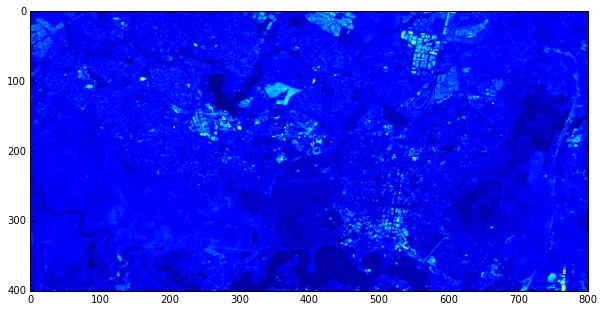

In [10]:
plt.figure(figsize=(10,7))
plt.imshow(band_red.isel(time=0).sel(latitude=slice(-35.2,-35.3), longitude=slice(149.0, 149.2)) / 10000.0)

How about we mind the mean value all times for band 6.

In [11]:
ndvi = (band_nir - band_red) / (band_nir + band_red * 1.)

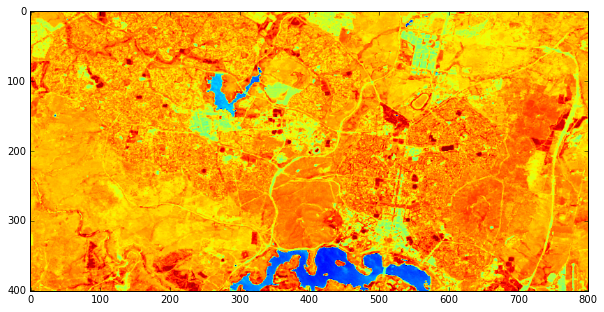

In [12]:
plt.figure(figsize=(10,7))
plt.imshow(ndvi.isel(time=0).sel(latitude=slice(-35.2,-35.3), longitude=slice(149.0, 149.2)) / 10000.0)

In [15]:
seasonal_groups = ndvi.sel(latitude=slice(-35.2,-35.3), longitude=slice(149.0, 149.2)).groupby('time.season')
seasonal_groups.groups

{'DJF': [0, 1, 2], 'JJA': [8, 9, 10, 11], 'MAM': [3, 4, 5, 6, 7]}

In [16]:
seasonal = seasonal_groups.apply(xray.DataArray.mean, dim='time').load()

IndexError: too many indices for array

Traceback
---------
  File "C:\Users\u42007\AppData\Local\Continuum\Anaconda2\lib\site-packages\dask\async.py", line 266, in execute_task
    result = _execute_task(task, data)
  File "C:\Users\u42007\AppData\Local\Continuum\Anaconda2\lib\site-packages\dask\async.py", line 249, in _execute_task
    return func(*args2)


In [ ]:
plt.imshow(seasonal.sel(season='DJF'))

In [ ]:
seasonal.sel(season='JJA').plot()

In [ ]:
seasonal.sel(season='MAM').plot()

We can also query a location across time

In [ ]:
pixel_drill = data['arrays']['band_1'].sel(latitude=-35.53, longitude=148.76)
pixel_drill.values

In [ ]:
pixel_drill.load()
plt.figure(figsize=(12,8))
pixel_drill.plot()
plt.show()

Or do something a tille more involved.

In [ ]:
band_1 = data['arrays']['band_1']
    band_4 = data['arrays']['band_4']
    band_6 = data['arrays']['band_6']

    band_1_mean = band_1.mean(axis=0)
    band_4_mean = band_4.mean(axis=0)
    band_6_mean = band_6.mean(axis=0)

    band_1_scaled = (band_1_mean - band_1_mean.min()) / float(band_1_mean.max() - band_1_mean.min())
    band_4_scaled = (band_4_mean - band_4_mean.min()) / float(band_4_mean.max() - band_4_mean.min())
    band_6_scaled = (band_6_mean - band_6_mean.min()) / float(band_6_mean.max() - band_6_mean.min())

    rgb = xray.concat([band_6_scaled, band_4_scaled, band_1_scaled], 'color')
    rgb = rgb.transpose('latitude', 'longitude', 'color')
    
    plt.figure(figsize=(10,8))
    plt.imshow(rgb.sel(latitude=slice(-35.2,-35.6), longitude=slice(148.9, 149.3)))